<br>

# Project 4 - Elon Buys Twitter 
## Sentiment Analysis

DATA 620
Bonnie Cooper, George Cruz Deschamps, Rob Hodde

In [1]:
import sys
#!{sys.executable} -m pip install wordcloud
#!{sys.executable} -m pip install pysentimiento
#!{sys.executable} -m pip install --upgrade pandas

### Import Libraries

In [2]:

# utilities
import re
import numpy as np
import pandas as pd
import pickle 
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
# To read faster the large data 
from dask import dataframe as df1


### Read Data

In [3]:
# Importing the dataset
elongate_tweets_file = 'raw_data/elongate_tweets.csv'
regular_tweets_file = 'raw_data/elonmusktwitter_tweets.csv'
chunk = pd.read_csv(elongate_tweets_file, sep=',', index_col=False, dtype='unicode', chunksize=1000)
elongate_df = pd.concat(chunk)

chunk = pd.read_csv(regular_tweets_file, sep=',', index_col=False, dtype='unicode', chunksize=1000)
regular_df = pd.concat(chunk)

elongate_df.sample(5)


,date,id,content,lang,replyCount,retweetCount,likeCount,inReplyToTweetId,inReplyToUser,mentionedUsers
218630,2022-05-04 01:13:37+00:00,1521659279685607429,"@DraBetalacerda @elonmusk Welcome back, doc!!👏...",en,0,0,1,1.5215488166793298e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u..."
21430,2022-05-04 21:21:18+00:00,1521963202405359624,https://t.co/HmBPZwmu11 My Gen 1 (Fast) NFT fo...,en,0,0,1,NaN,NaN,NaN
91352,2022-05-04 14:35:28+00:00,1521861070201421824,@MsCryptomom1 @elonmusk @boredape101 Great day...,en,0,0,0,1.5218488466614395e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u..."
468319,2022-05-03 00:30:18+00:00,1521285988198207490,@AGomezler @TomBrady @elonmusk https://t.co/kz...,und,0,0,0,1.5148114751429837e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u..."
153262,2022-05-04 10:20:12+00:00,1521796828743618562,WAIT HOLD UP @elonmusk don’t play with my hear...,en,10,9,56,NaN,NaN,"[{'_type': 'snscrape.modules.twitter.User', 'u..."


In [4]:
print(elongate_df.size)
elongate_filter = (elongate_df['lang'] == 'en')

elongate_df = elongate_df[elongate_filter]
print(elongate_df.size)
elongate_df.head(5)

4783210
3597810


,date,id,content,lang,replyCount,retweetCount,likeCount,inReplyToTweetId,inReplyToUser,mentionedUsers
0,2022-05-04 23:59:59+00:00,1522003135794929665,@elonmusk @bevedoni It would make us happy if ...,en,0,0,0,1.5219985677574267e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u..."
1,2022-05-04 23:59:59+00:00,1522003134612127746,@Crypto_Highland @RatsoLicksy @CliffToken @elo...,en,1,0,2,1.522002058949415e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u..."
2,2022-05-04 23:59:59+00:00,1522003134557663235,@elonmusk @bevedoni Word !,en,0,0,0,1.5219985677574267e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u..."
3,2022-05-04 23:59:59+00:00,1522003134238715910,@teslaownersSV @elonmusk He was joking and her...,en,0,0,0,1.5217191082528236e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u..."
4,2022-05-04 23:59:58+00:00,1522003132162658304,@elonmusk @bevedoni It’s very true!,en,0,0,0,1.5219985677574267e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u..."


### Perform Sentiment and Emotion Analysis

We will be using `pysentimiento` a Python Toolkit for Sentiment Analysis and SocialNLP tasks that uses pre-trained Bert and language models to perform the sentiment analysis. 

#### Sentiment Analyzer

In [5]:
from pysentimiento import create_analyzer
sentiment_analyzer = create_analyzer(task="sentiment", lang="en")


#### Emotion Analyzer

In [6]:
emotion_analyzer = create_analyzer(task="emotion", lang="en")

loading configuration file https://huggingface.co/finiteautomata/bertweet-base-emotion-analysis/resolve/main/config.json from cache at C:\Users\georg/.cache\huggingface\transformers\c246eed05359b1a49c45955b0265b488e35b0cbd2628e3ead7dd54c8815162ee.a2dff24b4e0a884c6d58a09968c5b68e7391e749eb698ad92541818d420fd01b
Model config RobertaConfig {
  "_name_or_path": "finiteautomata/bertweet-base-emotion-analysis",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "others",
    "1": "joy",
    "2": "sadness",
    "3": "anger",
    "4": "surprise",
    "5": "disgust",
    "6": "fear"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "disgust": 5,
    "fear": 6,
    "joy": 1,
    "others": 0,

In [7]:
import pandas as pd
pd.__version__
#%pip install pandas==1.4.1

'1.4.2'

In [19]:
f3 = open('raw_data/elonmusktwitter_tweets_df.obj', 'rb')
df3 = pickle.load(f3)
df3.shape[0]

1475486

In [9]:
#Sentiment Analysis returns 
#NEU = Neutral = 50
#POS = Positive = 100
#NEG = Negative = 0
def analyze(content):
  result = 'Neutral'
  if type(content) == str:
    res = sentiment_analyzer.predict(content)
    if res.output == 'NEG':
      result = 'Negative'
    elif res.output == 'POS':
      result = 'Positive'
  return result


In [20]:

regular_df_sample = regular_df.sample(n=10000)
elongate_df_sample = elongate_df.sample(n=10000)
regular_df_sample.head(5)


,date,id,user_ID,user_name,user_location,content,lang,replyCount,retweetCount,likeCount,inReplyToTweetId,inReplyToUser_ID,inReplyToUser_name,mentionedUsers_ID,mentionedUsers_name
1222716,2022-04-28 21:23:37+00:00,1519789457909727233,1499093027255635976,Jimmyzoupa,NaN,@seanhannity How much would you like to bet @e...,en,0,0,0,1.519788058417283e+18,41634520,seanhannity,"[41634520, 44196397]","['seanhannity', 'elonmusk']"
798121,2022-04-26 18:15:44+00:00,1519017399068274688,1131661879930171396,AlfredoVilaboa,Hurlingham,@JMilei @elonmusk @realDonaldTrump ahora entie...,es,0,0,0,1.518784890174464e+18,4020276615,JMilei,"[4020276615, 44196397, 25073877]","['JMilei', 'elonmusk', 'realDonaldTrump']"
135547,2022-04-06 12:26:45+00:00,1511681817329418242,34121956,squamishsusan,Biosphere,After buying over 9% of @Twitter @elonmusk tak...,en,0,0,0,NaN,0,0,"[783214, 44196397]","['Twitter', 'elonmusk']"
44169,2022-04-04 12:16:54+00:00,1510954561736830982,540587274,KilaFateh,Union of India,"Haha 😃 true to his tweet, @elonmusk is now hol...",en,0,0,1,NaN,0,0,"[44196397, 783214, 1291945442]","['elonmusk', 'Twitter', 'PPathole']"
692105,2022-04-22 15:07:30+00:00,1517520478235156480,97767641,Optionparty,Minnesota,@elonmusk Sell lots of Naked Puts on Twitter.\...,en,0,0,1,1.5172150665501164e+18,44196397,elonmusk,[44196397],['elonmusk']


#### Performing the Sentiment Analysis. 

Instead of creating, training and testing our own model, we opted for using the pre-trained model in pySentimiento. It still takes a long time processing, which is why we took a random sample of 10,000 tweets from both sources: `regular` and `elon_buys_twitter` tweets. 

In [21]:
regular_df_sample_content = regular_df_sample['content'].values
elongate_df_sample_content = elongate_df_sample['content'].values

elongate_df_sentiment = [analyze(x) for x in elongate_df_sample_content]
# Saving the objects since the analysis takes a long time
with open('raw_data/elongate_df_sentiment.obj', 'wb') as elongate_df_sentiment_file:
  pickle.dump(elongate_df_sentiment, elongate_df_sentiment_file)
regular_df_sentiment = [analyze(x) for x in regular_df_sample_content]
# Saving the objects since the analysis takes a long time
with open('raw_data/regular_df_sentiment.obj', 'wb') as regular_df_sentiment_file:
  pickle.dump(regular_df_sentiment, regular_df_sentiment_file)

Encoding Categorical Variable:

Initially I have mapped an index to the different levels of sentiment:

In [26]:
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()
pred_lbl = lbl.fit_transform(regular_df_sentiment)
mappings = {index: label for index, label in enumerate(lbl.classes_)}
mappings

{0: 'Negative', 1: 'Neutral', 2: 'Positive'}

In [27]:
dummy_features = pd.get_dummies(regular_df_sentiment)
dummy_features


,Negative,Neutral,Positive
0,0,1,0
1,0,1,0
2,0,0,1
3,0,0,1
4,0,1,0
...,...,...,...
9995,1,0,0
9996,0,1,0
9997,0,1,0
9998,0,1,0


In [28]:
regular_df_sample['sentiment'] = regular_df_sentiment
regular_df_sample.head(5)['sentiment']

1222716     Neutral
798121      Neutral
135547     Positive
44169      Positive
692105      Neutral
Name: sentiment, dtype: object

In [29]:
at=pd.concat([regular_df_sample[['content', 'sentiment']],
dummy_features.set_index(regular_df_sample.index)], axis=1)
at.head(9)
#This file gets saved as 'regular_sentiment_sample.csv' for future reference

,content,sentiment,Negative,Neutral,Positive
1222716,@seanhannity How much would you like to bet @e...,Neutral,0,1,0
798121,@JMilei @elonmusk @realDonaldTrump ahora entie...,Neutral,0,1,0
135547,After buying over 9% of @Twitter @elonmusk tak...,Positive,0,0,1
44169,"Haha 😃 true to his tweet, @elonmusk is now hol...",Positive,0,0,1
692105,@elonmusk Sell lots of Naked Puts on Twitter.\...,Neutral,0,1,0
912279,I guess Elon Musk was able to buy Twitter beca...,Neutral,0,1,0
168998,@Benmzondo @Blacksmitheart @laurenboebert @elo...,Neutral,0,1,0
573493,What if @elonmusk buys @Twitter and replaces i...,Neutral,0,1,0
567274,"@elonmusk 'Wurg hom, Dirkie!' @Twitter !! 😂",Positive,0,0,1


In [37]:
print('REGULAR TWEETS:')
print('Negative Proportion:', at['Negative'].mean())
print('Positive Proportion:', at['Positive'].mean())
print('Neutral Proportion:', at['Neutral'].mean())

REGULAR TWEETS:
Negative Proportion: 0.3173
Positive Proportion: 0.1199
Neutral Proportion: 0.5628


Elon Tweets About Twitter Purchase: 

In [39]:
elongate_dummy_features = pd.get_dummies(elongate_df_sentiment)
elongate_dummy_features

elongate_df_sample['sentiment'] = elongate_df_sentiment
elongate_df_sample.head(5)['sentiment']

elongate_at=pd.concat([elongate_df_sample[['content', 'sentiment']],
elongate_dummy_features.set_index(elongate_df_sample.index)], axis=1)
elongate_at.head(9)
#This table gets saved as 'elongate_sentiment_sample.csv' for future reference

print('TWITTER PURCHASE SENTIMENT:')
print('Negative Proportion:', elongate_at['Negative'].mean())
print('Positive Proportion:', elongate_at['Positive'].mean())
print('Neutral Proportion:', elongate_at['Neutral'].mean())

TWITTER PURCHASE SENTIMENT:
Negative Proportion: 0.3574
Positive Proportion: 0.2235
Neutral Proportion: 0.4191


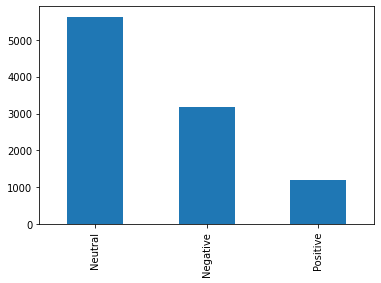

In [42]:
at['sentiment'].value_counts().plot(kind='bar')
#at.to_csv('raw_data/regular_sentiment_sample.csv')

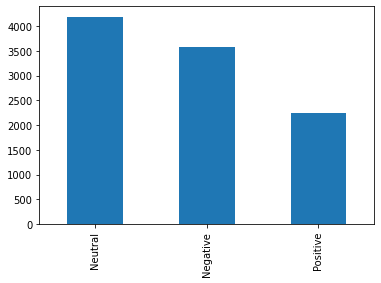

In [43]:
elongate_at['sentiment'].value_counts().plot(kind='bar')
#elongate_at.to_csv('raw_data/elongate_sentiment_sample.csv')

In both the `regular` and `elon buys twitter` sets of tweets, we notice a majority of the sentiment is neutral.  However, can see a more marked reaction to the news that Elon wants to buy Twitter.  This makes sense, we see a greater positive sentiment on these tweets than on mundane Elon Musk Tweets but, at the same time, we see an increase in the negative sentiment tweets as well. It can be argued that the news is more interesting and, therefore, reduces the apathy of the normal tweets. 

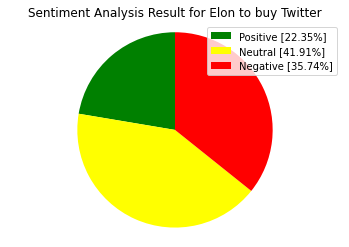

In [45]:
#Creating PieCart
negative = elongate_at['Negative'].mean() * 100
positive = elongate_at['Positive'].mean() * 100
neutral = elongate_at['Neutral'].mean() * 100
labels = ['Positive ['+str(positive)+'%]',
 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
sizes = [positive, neutral, negative]
colors = ['green', 'yellow','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for Elon to buy Twitter" )
plt.axis('equal')
plt.show()

#### Cleaning Tweets to further analyze Sentiment

In [47]:
at.drop_duplicates(inplace = True)
at.describe()


,Negative,Neutral,Positive
count,9917.000000,9917.000000,9917.000000
mean,0.319956,0.559343,0.120702
std,0.466483,0.496491,0.325797
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


In [48]:

elongate_at.drop_duplicates(inplace = True)
elongate_at.describe()

,Negative,Neutral,Positive
count,9964.000000,9964.000000,9964.000000
mean,0.358691,0.420413,0.220895
std,0.479640,0.493650,0.414871
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


#### Preprocessing the Tweets, cleaning them 

In [73]:
from pysentimiento.preprocessing import preprocess_tweet


In [82]:

#Cleaning Text (RT, Punctuation etc)
#Creating new dataframe and new features
tw_list = pd.DataFrame(elongate_at['content'].values.tolist())
tw_list['text'] = tw_list[0]
tw_list.head(10)

#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0–9]+)"," ",x)

def process(x):
  result = ''
  if type(x) == str:
    result = rt(preprocess_tweet(x))
  return result
    
tw_list["text"] = tw_list.text.map(process)
tw_list["text"] = tw_list.text.str.lower()
tw_list.head(10)



,0,text
0,@0__1 @elonmusk I was ahead of the time.,i was ahead of the time.
1,@elonmusk Lol too funny! Check out the @troopr...,lol too funny! check out the
2,@shellshellBrow1 @elonmusk hasn't quite takin ...,hasn't quite takin the reigns yet...
3,Freedom Warrior @elonmusk is declaring #TOTALW...,freedom warrior is declaring totalwar on his...
4,@elonmusk so we have tesla balls,so we have tesla balls
5,@JeffreyGuterman @elonmusk This guy's a doctor...,this guy's a doctor now? when did he chang...
6,@CryptoAcca @_winston_FSD @SirineAti @elonmusk...,i loved him on bridgerton.
7,@filczer_shaun @BorislavKostad1 @elonmusk Comm...,comments without research are emotionall...
8,@elonmusk U do the sign yesterday!!👌666\nhttps...,u do the sign yesterday!! emoji señal de apr...
9,@elonmusk @stats_feed Yes!! Let's colonize space!,yes!! let's colonize space!


In [90]:
#Cleaning Elongate_At content 
elongate_at["content"] = elongate_at["content"].apply(process)

In [91]:
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = elongate_at[elongate_at['sentiment'] == 'Negative']
tw_list_positive = elongate_at[elongate_at['sentiment'] == 'Positive']
tw_list_neutral = elongate_at[elongate_at['sentiment'] ==  'Neutral']

#### Another look at the Proportions.

In [92]:
def count_values_in_column(data,feature):
  total=data.loc[:,feature].value_counts(dropna=False)
  percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
  return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

#Count_values for sentiment
count_values_in_column(elongate_at,'sentiment')

,Total,Percentage
Neutral,4189,42.04
Negative,3574,35.87
Positive,2201,22.09


### WordCloud

We can also take a look at a WordCloud.

In [106]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

#Function to Create Wordcloud
def create_wordcloud(text, filename, mirror= False):
  mask_name = 'images/elon_mask.png'
  if mirror:
    mask_name = 'images/elon_mask_mirror.png'

  mask = np.array(Image.open(mask_name))
  stopwords = set(STOPWORDS)
  new_stopwords = {'thing', 'llorando', 'lol', 'señal', 'emoji','yet', "emoji'", "risa"}
  stopwords.update(new_stopwords)
  
  wc = WordCloud(background_color='white',
    mask = mask,
    max_words=3000,
    stopwords=stopwords,
    repeat=True)
  wc.generate(str(text))
  wc.to_file('images/' + filename)
  print('Word Cloud Saved Successfully')
  path='images/' + filename
  display(Image.open(path))



#### All Tweets WordCloud

Word Cloud Saved Successfully


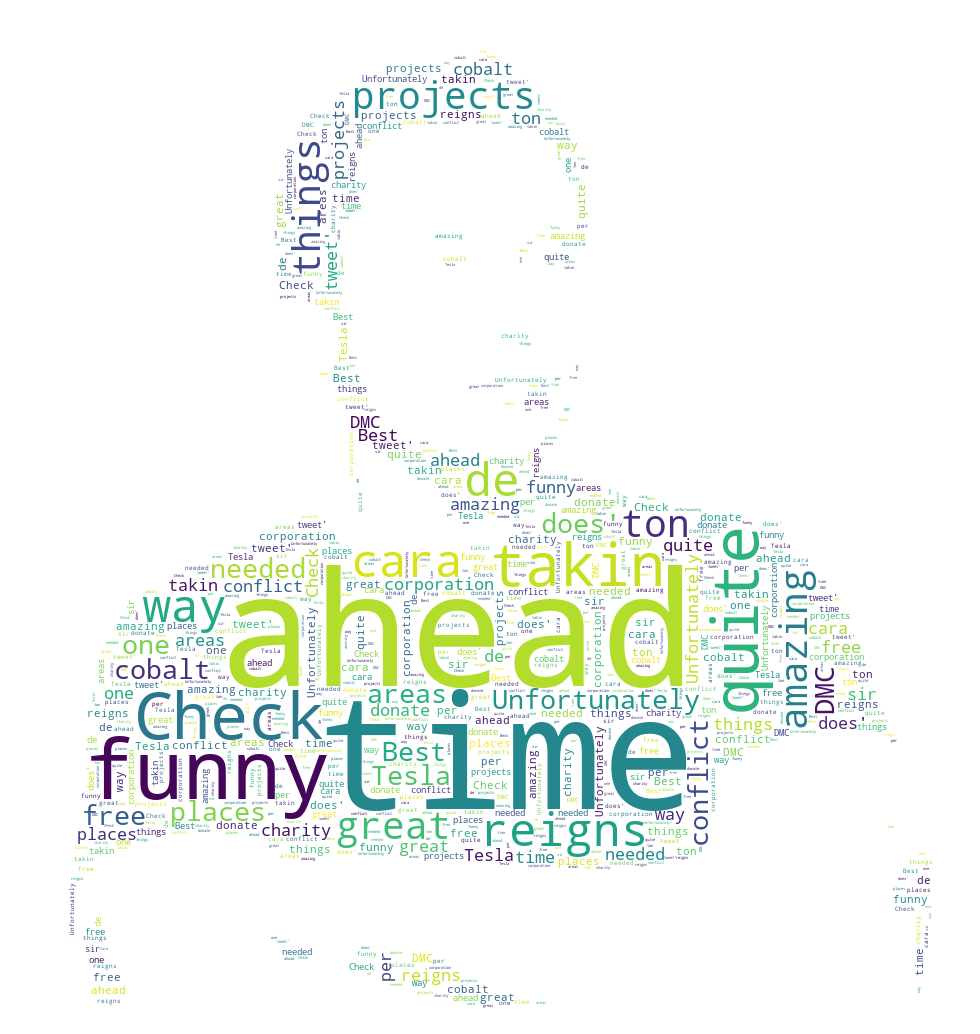

In [107]:
#Creating wordcloud for all tweets
create_wordcloud(elongate_at['content'].values, 'elongate_wc.png')

#### Positive Tweets WordCloud

Word Cloud Saved Successfully


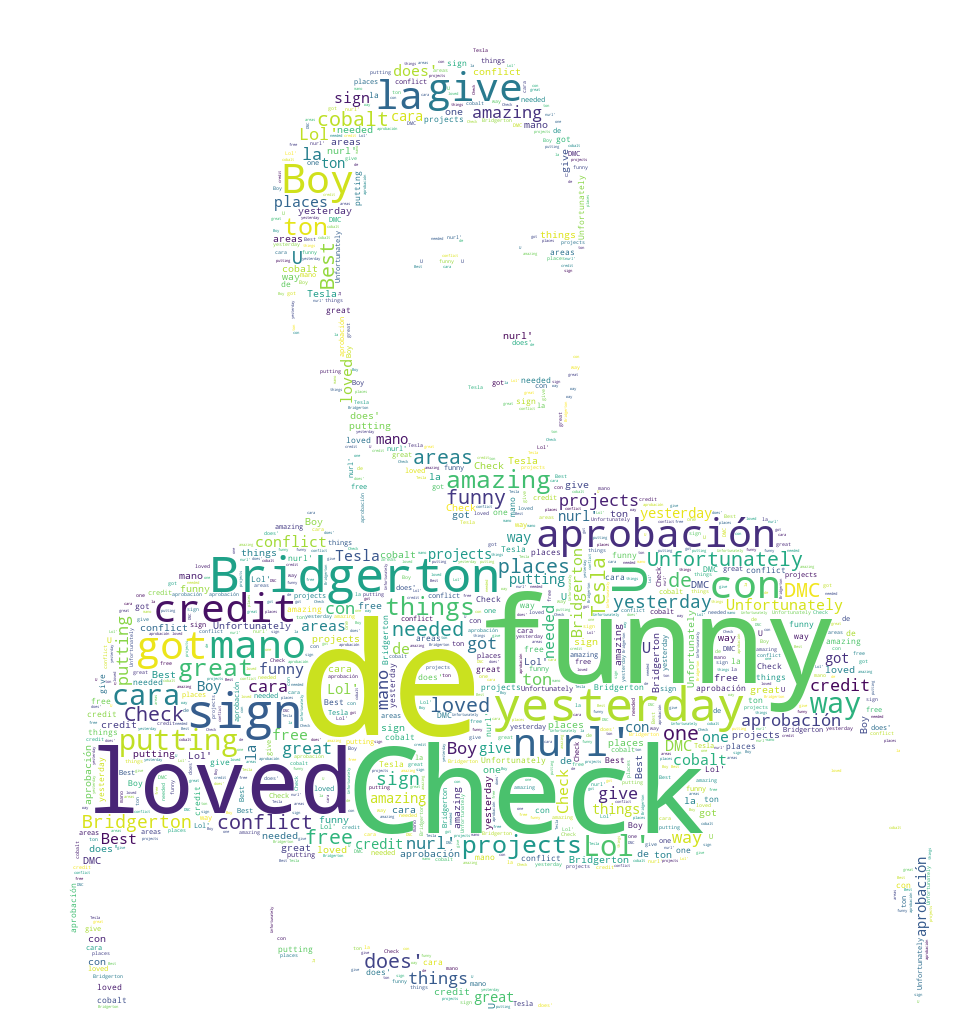

In [108]:
create_wordcloud(tw_list_positive['content'].values, 'elongate_positive_wc.png')

#### Negative Sentiment WordCloud

Word Cloud Saved Successfully


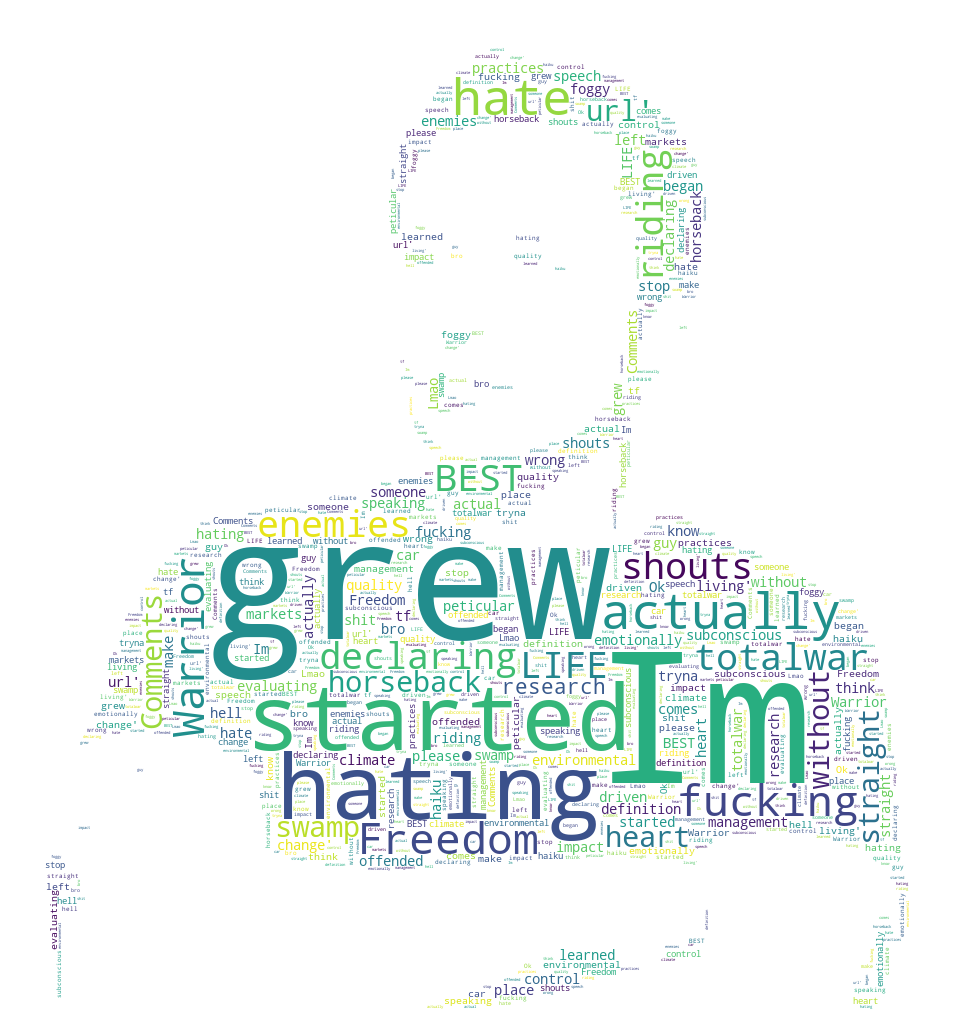

In [109]:
create_wordcloud(tw_list_negative['content'].values, 'elongate_negative_wc.png', True)

### Conclusion

For this particular Sentiment Analysis, we decided to go with a good pretrained model, and the results are good enough. It made it very easy to perform text analysis with adequate results while saving us some time. 

As per Elon Musk attempting to buy Twitter, we can definitely say that it caused a stir.  While normal Elon Tweets are at 56% neutrality with 12% positive sentiment and 32% negative sentiment.  His announcement of attempting to buy Twitter got an overwhelmingly positive response, almost doubling the positive tweets to 22%.  Negative Sentiment Tweets also grew but to about 35% for a most modest gain. 

It can be asserted that, at least, it led to less indifferent or apathic comments. 